In [ ]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import json

# Load datasets
graduates_data = pd.read_csv('C:/Users/Omen/OneDrive/Desktop/upload/ela_analysis/data/graduates-major-data.csv', sep=';')
students_data = pd.read_csv('C:/Users/Omen/OneDrive/Desktop/upload/ela_analysis/data/students-major-data.csv', sep=';')

# Define key variables for analysis
P_WOJ = graduates_data['P_WOJ']  # Województwo lokalizacji jednostki dydaktycznej
P_ME_ZAR = graduates_data['P_ME_ZAR']  # Mediana wynagrodzeń absolwentów
P_WWZ = graduates_data['P_WWZ']  # Względny Wskaźnik Zarobków
P_WWB = graduates_data['P_WWB']  # Względny Wskaźnik Bezrobocia
P_WWB_DOSW = graduates_data['P_WWB_DOSW']  # Wskaźnik Bezrobocia dla absolwentów z doświadczeniem
P_WWB_NDOSW = graduates_data['P_WWB_NDOSW']  # Wskaźnik Bezrobocia dla absolwentów bez doświadczenia
P_CZAS_PRACA_DOSW = graduates_data['P_CZAS_PRACA_DOSW']  # Czas do pierwszej pracy dla absolwentów z doświadczeniem
P_CZAS_PRACA_NDOSW = graduates_data['P_CZAS_PRACA_NDOSW']  # Czas do pierwszej pracy dla absolwentów bez doświadczenia
P_ME_ZAR_DOSW = graduates_data['P_ME_ZAR_DOSW']  # Mediana wynagrodzeń dla absolwentów z doświadczeniem
P_ME_ZAR_NDOSW = graduates_data['P_ME_ZAR_NDOSW']  # Mediana wynagrodzeń dla absolwentów bez doświadczenia
# P_N = students_data['P_N']  # Liczba studentów
P_N = graduates_data['P_N'] # Liczba absolwentów
P_POZIOM = graduates_data['P_POZIOM']  # Poziom studiów
P_FORMA = graduates_data['P_FORMA']  # Forma studiów
P_ROKDYP = graduates_data['P_ROKDYP'] # Rok ukończenia studiów
P_ROK_OD = students_data['P_ROK_OD'] # Rok rozpoczęcia studiów
P_KIERUNEK_NAZWA = graduates_data['P_KIERUNEK_NAZWA'] # Pełna nazwa kierunku
P_ME_ZAR_P1 = graduates_data['P_ME_ZAR_P1'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 1 roku po uzyskaniu dyplomu
P_ME_ZAR_P2 = graduates_data['P_ME_ZAR_P2'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 2 roku po uzyskaniu dyplomu
P_ME_ZAR_P3 = graduates_data['P_ME_ZAR_P3'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 3 roku po uzyskaniu dyplomu
P_ME_ZAR_P4 = graduates_data['P_ME_ZAR_P4'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 4 roku po uzyskaniu dyplomu
P_ME_ZAR_P5 = graduates_data['P_ME_ZAR_P5'] # Mediana średnich miesięcznych wynagrodzeń absolwentów ze wszystkich źródeł w 5 roku po uzyskaniu dyplomu
P_N_SEMESTR = graduates_data['P_N_SEMESTR'] # Liczba semestrów
P_NAZWA_UCZELNI = graduates_data['P_NAZWA_UCZELNI'] # Nazwa uczelni

# Convert selected columns with numeric strings to float
for col in graduates_data.columns:
    if any(keyword in col for keyword in ['P_ME', 'P_WWZ', 'P_WWB', 'P_CZAS']):
        graduates_data[col] = graduates_data[col].astype(str).str.replace(',', '.')
        graduates_data[col] = pd.to_numeric(graduates_data[col], errors='coerce')


In [ ]:
# Function to map a field to a category based on keywords
def add_field_column(dataframe, column_name):
    """
    Add a new column 'Dziedzina' to the given DataFrame based on keywords in the specified column.
    
    Args:
        dataframe (pd.DataFrame): The DataFrame to modify.
        column_name (str): The name of the column containing course names.

    Returns:
        pd.DataFrame: The updated DataFrame with the new 'Dziedzina' column.
    """
    # Dictionary mapping phrases to fields
    keywords_to_dziedzina = {
        "Prawo": "Nauki prawne",
        "Psychol": "Psychologia",
        "Automat": "Automatyka",
        "Informat": "Informatyka",
        "Zarządzanie": "Zarządzanie",
        "lekarski": "Kierunek lekarski",
        "Ekonom": "Ekonomia",
        "Mechani": "Inżynieria mechaniczna",
        "Chem": "Chemia",
        "Budowni": "Inżynieria lądowa",
        "Archit": "Architektura",
        "Elektr": "Inżynieria elektryczna",
        "środowi": "Inżynieria środowiskowa",
    }
    
    # Function to assign a field based on keywords
    def assign_field(course_name):
        for keyword, field in keywords_to_dziedzina.items():
            if keyword.lower() in course_name.lower():  # Check if keyword exists in the course name
                return field
        return "Inne"  # Assign "Inne" if no match is found

    # Apply the function to create the new column
    dataframe['Dziedzina'] = dataframe[column_name].apply(assign_field)

    return dataframe

# Apply the function to the graduates_data DataFrame
graduates_data = add_field_column(graduates_data, 'P_KIERUNEK_NAZWA')

In [70]:
def add_adjusted_salary_columns(data, median_dict):
    """
    Adds columns to the graduates_data DataFrame where the value is
    P_ME_ZAR_P1 through P_ME_ZAR_P5 divided by the median salary based on the year in P_ROKDYP.

    Args:
        data (pd.DataFrame): The graduates_data DataFrame.
        median_dict (dict): A dictionary containing median salaries for specific years.

    Returns:
        pd.DataFrame: The updated DataFrame with the new columns.
    """
    # Define the corresponding salary and new column suffixes
    salary_columns = [f"P_ME_ZAR_P{i}" for i in range(1, 6)]
    adjusted_columns = [f"P_WWZ_P{i}" for i in range(1, 6)]

    # Function to calculate the adjusted salary for a specific column
    def calculate_adjusted_salary(row, salary_column, offset):
        year = row['P_ROKDYP'] + offset
        if year in median_dict:
            return row[salary_column] / median_dict[year]
        return None  # Return None if the year is not in the median dictionary

    # Loop through each salary column and create the corresponding adjusted column
    for i, (salary_col, adjusted_col) in enumerate(zip(salary_columns, adjusted_columns), start=1):
        offset = i  # P_ME_ZAR_P1 corresponds to +1 year, P_ME_ZAR_P2 to +2 years, etc.
        data[adjusted_col] = data.apply(lambda row: calculate_adjusted_salary(row, salary_col, offset), axis=1)

    return data

# Define the median dictionary
median = {
2014: 3291.56,
2015: 3401.11,
2016: 3510.67,
2017: 3802.82,
2018: 4094.98,
2019: 4398.82,
2020: 4702.66,
2021: 5202.14,
2022: 5701.62,
2023: 6100.81,
2024: 6500.00
}

# Add the new column to graduates_data
graduates_data = add_adjusted_salary_columns(graduates_data, median)

In [ ]:
def plot_relative_salary_histograms(data, column_prefix="P_WWZ_P"):
    """
    Plots histograms for the relative salary columns (e.g., P_WWZ_P1 to P_WWZ_P5).

    Args:
        data (pd.DataFrame): The DataFrame containing the relative salary columns.
        column_prefix (str): The prefix of the columns to plot (default is 'P_WWZ_P').

    Returns:
        None: Displays the histograms.
    """
    # Import necessary libraries
    import matplotlib.pyplot as plt

    # Loop through the columns P_WWZ_P1 to P_WWZ_P5
    for i in range(1, 6):
        column = f"{column_prefix}{i}"
        if column in data.columns:
            # Drop NaN values for the current column
            column_data = data[column].dropna()

            # Plot the histogram
            plt.figure(figsize=(8, 5))
            plt.hist(column_data, bins=30, edgecolor='black', alpha=0.7)

            # Set plot labels and title
            plt.xlabel("Relative Earnings")
            plt.ylabel("Number of Samples")
            plt.title(f"Histogram of {column} Relative Earnings")

            # Show the plot
            plt.show()

# Example usage
plot_relative_salary_histograms(graduates_data)


In [ ]:
# Create a dictionary to store mappings for each column
label_mappings = {}

# Encode variables and save mappings
for column in ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']:
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Fit and transform the column
    graduates_data[column] = label_encoder.fit_transform(graduates_data[column])
    
    # Store the mapping: original value -> encoded value
    label_mappings[column] = {str(original): encoded for encoded, original in enumerate(label_encoder.classes_)}

# # Save mappings to a file (optional)
# import json
with open('label_mappings.json', 'w', encoding='utf-8') as f:
    json.dump(label_mappings, f, ensure_ascii=False, indent=4)

# Print the mappings
for column, mapping in label_mappings.items():
    print(f"Mapping for {column}:")
    for original, encoded in mapping.items():
        print(f"  {original}: {encoded}")

In [ ]:
import json

# Path to the .json file
file_path = 'label_mappings.json'

# Load the .json file
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Now `data` is a regular Python dictionary
print(type(data))  # <class 'dict'>
print(data)

# Function to find a key based on a value
def get_key_from_value(mapping, value):
    reverse_mapping = {v: k for k, v in mapping.items()}
    return reverse_mapping.get(value, "Value not found")

# Example usage
value_to_find = 0
result = get_key_from_value(data['P_FORMA'], value_to_find)
print(result)

In [ ]:
graduates_data['P_WWZ_P5'].describe()

# MODELS

In [ ]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

year = 5

# Assuming 'graduates_data' is your DataFrame loaded from a CSV or other source
# Replace this with your actual data loading code
# graduates_data = pd.read_csv('your_data.csv')

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Drop rows with missing values in specified columns
columns_to_check = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina', f'P_WWZ_P{year}']
graduates_data_copy = graduates_data_copy.dropna(subset=columns_to_check)

# List of categorical features
categorical_features = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']

# Label Encoding for categorical variables
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    graduates_data_copy[col] = le.fit_transform(graduates_data_copy[col])
    label_encoders[col] = le

# Features and target variable
features = graduates_data_copy[categorical_features]
target = graduates_data_copy[f'P_WWZ_P{year}']

# Convert to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Custom Dataset
class GraduatesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define your RegressionModel
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)        # Second hidden layer
        self.fc3 = nn.Linear(64, 32)         # Third hidden layer
        self.fc4 = nn.Linear(32, 1)          # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
model = RegressionModel(input_dim=len(categorical_features))

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create datasets
train_dataset = GraduatesDataset(X_train, y_train)
test_dataset = GraduatesDataset(X_test, y_test)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
epochs = 50  # Number of epochs
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * batch_x.size(0)
    epoch_train_loss /= len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    epoch_valid_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            epoch_valid_loss += loss.item() * batch_x.size(0)
    epoch_valid_loss /= len(valid_loader.dataset)
    valid_losses.append(epoch_valid_loss)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Training Loss: {epoch_train_loss:.4f}, "
          f"Validation Loss: {epoch_valid_loss:.4f}")


# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).numpy()
    y_test_actual = y_test.numpy()

# Calculate regression metrics
mae = mean_absolute_error(y_test_actual, test_predictions)
mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, test_predictions)
mape = mean_absolute_percentage_error(y_test_actual, test_predictions)

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

plt.scatter(y_test_actual, test_predictions, alpha=0.5)
plt.xlabel("Rzeczywisty wskaźnik zarobków")
plt.ylabel("Przewidywany wskaźnik zarobków")
plt.title(f"Rzeczywiste vs Przewidywane zarobki w {year} roku po ukończeniu studiów")
plt.plot(
    [y_test_actual.min(), y_test_actual.max()],
    [y_test_actual.min(), y_test_actual.max()],
    'r--'
)  # Line y=x
plt.show()

residuals = y_test_actual - test_predictions
plt.scatter(test_predictions, residuals, alpha=0.5)
plt.xlabel("Przewidywane wartości")
plt.ylabel("Reszty")
plt.title("Wykres reszt")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


sns.histplot(residuals, kde=False)
plt.title("Rozkład reszt")
plt.xlabel("Reszty")
plt.ylabel("Częstotliwość")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Strata walidacyjna')
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.title("Strata treningowa i walidacyjna w kolejnych epokach")
plt.legend()
plt.show()


In [76]:
def test_model(model, input_features, label_encoders):
    """
    Test the trained PyTorch model with a single set of input features.

    Args:
        model (torch.nn.Module): Trained PyTorch model.
        input_features (dict): Input features as a dictionary with keys:
            ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
        label_encoders (dict): Dictionary of LabelEncoders for categorical features.

    Returns:
        float: Predicted value for `P_WWZ_P2`.
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Encode categorical input features
    encoded_features = []
    for feature, value in input_features.items():
        if feature in label_encoders:
            encoded_value = label_encoders[feature].transform([value])[0]
        else:
            encoded_value = value
        encoded_features.append(encoded_value)

    # Convert encoded features to a PyTorch tensor
    input_tensor = torch.tensor([encoded_features], dtype=torch.float32)

    # Make a prediction
    with torch.no_grad():
        prediction = model(input_tensor).numpy()[0, 0]

    return prediction

## Funkcje 

In [ ]:
# def rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years=5):
#     """
#     Iteratively generate predictions for future_years beyond the known data.
    
#     Args:
#         model (nn.Module): The trained LSTM model.
#         known_wwz (list[float]): List of WWZ values for years 1..5.
#         woj, poziom, forma, dziedz (float): Encoded categorical features.
#         future_years (int): How many future years to predict (e.g., 5 => years 6..10).
    
#     Returns:
#         A list of predicted WWZ values for the next future_years.
#     """
#     model.eval()
    
#     # Initialize hidden and cell states
#     h = torch.zeros(model.num_layers, 1, model.hidden_dim)  # batch_size = 1
#     c = torch.zeros(model.num_layers, 1, model.hidden_dim)  # batch_size = 1
    
#     # "Warm up" the LSTM with years 1..4 so it reaches the state for year 5
#     for t in range(4):
#         x_t = torch.tensor([[
#             woj, poziom, forma, dziedz, t+1, known_wwz[t]
#         ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
#         # Forward pass through the LSTM
#         out, (h, c) = model.lstm(x_t, (h, c))
    
#     # LSTM is now at the state corresponding to year 5
#     wwz_5 = known_wwz[4]  # The known year-5 value
#     future_preds = []
#     prev_wwz = wwz_5
    
#     # Predict future years (6..(5 + future_years)) iteratively
#     for i in range(future_years):
#         t_future = 5 + i
#         x_t = torch.tensor([[
#             woj, poziom, forma, dziedz, t_future, prev_wwz
#         ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
#         out, (h, c) = model.lstm(x_t, (h, c))
#         pred = model.fc(out)  # shape: (1, 1, 1)
#         pred_value = pred.item()
#         future_preds.append(pred_value)
        
#         # Update prev_wwz for the next iteration
#         prev_wwz = pred_value
    
#     return future_preds


# def predict_future(model, row, future_years=5):
#     """
#     A helper function that retrieves the known data from a row,
#     then calls rollout_prediction to forecast future years.
    
#     Args:
#         model (nn.Module): Trained LSTM model.
#         row (pd.Series): A row containing 'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
#                          and 'P_WWZ_P1'..'P_WWZ_P5'.
#         future_years (int): Number of future years to forecast.
    
#     Returns:
#         A list of forecasted WWZ values for the next 'future_years'.
#     """
#     model.eval()
    
#     known_wwz = [
#         row['P_WWZ_P1'],
#         row['P_WWZ_P2'],
#         row['P_WWZ_P3'],
#         row['P_WWZ_P4'],
#         row['P_WWZ_P5']
#     ]
#     woj = row['P_WOJ']
#     poziom = row['P_POZIOM']
#     forma = row['P_FORMA']
#     dziedz = row['Dziedzina']
    
#     return rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years)

# # In this example, for each row, we have 5 time steps corresponding to:
# #   P_WWZ_P1 ... P_WWZ_P5
# # We will build sequences of length 4 for the model to predict the next step
# # (e.g., year t+1 based on year t), a so-called "many-to-many" approach in LSTM.

# def build_sequences(row):
#     """
#     Builds a sequence of length 4 (features) and 4 targets from a row.
    
#     For each time step t = 1..4:
#       Input (X_t) = [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_Pt]
#       Output (Y_t) = P_WWZ_P(t+1)
    
#     The result is a tuple:
#       - seq_input: shape (4, input_dim)
#       - seq_output: shape (4,)
#     """
#     woj = row['P_WOJ']
#     poziom = row['P_POZIOM']
#     forma = row['P_FORMA']
#     dziedz = row['Dziedzina']
    
#     # Retrieve the 5 known WWZ values: P_WWZ_P1..P_WWZ_P5
#     wwz_values = [
#         row['P_WWZ_P1'],
#         row['P_WWZ_P2'],
#         row['P_WWZ_P3'],
#         row['P_WWZ_P4'],
#         row['P_WWZ_P5']
#     ]
    
#     seq_input = []
#     seq_output = []
    
#     # Build 4 time steps: from t=1 to t=4
#     for t in range(4):
#         year_t = t + 1
#         x_t = [woj, poziom, forma, dziedz, year_t, wwz_values[t]]
#         seq_input.append(x_t)
        
#         # The target is the next year's WWZ -> wwz_values[t+1]
#         seq_output.append(wwz_values[t + 1])
    
#     return np.array(seq_input, dtype=np.float32), np.array(seq_output, dtype=np.float32)


# # ============================================
# # 2. Dataset and DataLoader
# # ============================================
# class GraduatesLSTMDataset(Dataset):
#     """
#     A custom PyTorch Dataset for LSTM-based time series.
#     """
#     def __init__(self, X, y):
#         # Convert numpy arrays to torch tensors
#         self.X = torch.from_numpy(X)
#         self.y = torch.from_numpy(y)
    
#     def __len__(self):
#         return self.X.shape[0]
    
#     def __getitem__(self, idx):
#         return self.X[idx], self.y[idx]

# train_dataset = GraduatesLSTMDataset(X_train, y_train)
# test_dataset  = GraduatesLSTMDataset(X_test, y_test)

# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## LSTM 1 warstwa original 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ============================================
# 1. Data Preparation
# ============================================
# In this example, we assume you have a DataFrame called 'graduates_data' 
# with the following columns:
#   'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
#   'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
# You mentioned that you might have them already loaded.

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

# Encode categorical variables
categorical_cols = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    graduates_data_copy[col] = le.fit_transform(graduates_data_copy[col])
    label_encoders[col] = le

all_sequences = []
all_targets = []

for _, row in graduates_data_copy.iterrows():
    x_seq, y_seq = build_sequences(row)
    all_sequences.append(x_seq)
    all_targets.append(y_seq)

all_sequences = np.array(all_sequences)  # shape: (N, 4, input_dim)
all_targets = np.array(all_targets)      # shape: (N, 4)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_sequences, all_targets, test_size=0.2, random_state=42
)


# ============================================
# 3. LSTM Model Definition
# ============================================
class LSTMModel(nn.Module):
    """
    A simple LSTM model for many-to-many prediction.
    The model outputs a value for each time step.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        """
        Args:
            input_dim (int): Number of features at each time step.
            hidden_dim (int): Number of hidden units in the LSTM cell.
            num_layers (int): Number of stacked LSTM layers.
        """
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # batch_first=True => input shape: (batch, seq_length, input_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Final fully-connected layer maps hidden states to 1D output
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Forward pass through the LSTM.
        
        Args:
            x (Tensor): shape (batch_size, seq_length, input_dim)
        
        Returns:
            Tensor of shape (batch_size, seq_length) representing 
            predicted values at each time step.
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Map each hidden state to a single output
        out = self.fc(lstm_out)  # shape: (batch_size, seq_length, 1)
        
        # Remove the last dimension
        return out.squeeze(-1)   # shape: (batch_size, seq_length)

# Define input_dim (e.g., 6: [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_t])
input_dim = X_train.shape[2]

# Initialize model, loss function, and optimizer
model = LSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years=5):
    """
    Iteratively generate predictions for future_years beyond the known data.
    
    Args:
        model (nn.Module): The trained LSTM model.
        known_wwz (list[float]): List of WWZ values for years 1..5.
        woj, poziom, forma, dziedz (float): Encoded categorical features.
        future_years (int): How many future years to predict (e.g., 5 => years 6..10).
    
    Returns:
        A list of predicted WWZ values for the next future_years.
    """
    model.eval()
    
    # Initialize hidden and cell states
    h = torch.zeros(model.num_layers, 1, model.hidden_dim)  # batch_size = 1
    c = torch.zeros(model.num_layers, 1, model.hidden_dim)  # batch_size = 1
    
    # "Warm up" the LSTM with years 1..4 so it reaches the state for year 5
    for t in range(4):
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t+1, known_wwz[t]
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        # Forward pass through the LSTM
        out, (h, c) = model.lstm(x_t, (h, c))
    
    # LSTM is now at the state corresponding to year 5
    wwz_5 = known_wwz[4]  # The known year-5 value
    future_preds = []
    prev_wwz = wwz_5
    
    # Predict future years (6..(5 + future_years)) iteratively
    for i in range(future_years):
        t_future = 5 + i
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t_future, prev_wwz
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        out, (h, c) = model.lstm(x_t, (h, c))
        pred = model.fc(out)  # shape: (1, 1, 1)
        pred_value = pred.item()
        future_preds.append(pred_value)
        
        # Update prev_wwz for the next iteration
        prev_wwz = pred_value
    
    return future_preds


def predict_future(model, row, future_years=5):
    """
    A helper function that retrieves the known data from a row,
    then calls rollout_prediction to forecast future years.
    
    Args:
        model (nn.Module): Trained LSTM model.
        row (pd.Series): A row containing 'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
                         and 'P_WWZ_P1'..'P_WWZ_P5'.
        future_years (int): Number of future years to forecast.
    
    Returns:
        A list of forecasted WWZ values for the next 'future_years'.
    """
    model.eval()
    
    known_wwz = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']
    ]
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    return rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years)

# In this example, for each row, we have 5 time steps corresponding to:
#   P_WWZ_P1 ... P_WWZ_P5
# We will build sequences of length 4 for the model to predict the next step
# (e.g., year t+1 based on year t), a so-called "many-to-many" approach in LSTM.

def build_sequences(row):
    """
    Builds a sequence of length 4 (features) and 4 targets from a row.
    
    For each time step t = 1..4:
      Input (X_t) = [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_Pt]
      Output (Y_t) = P_WWZ_P(t+1)
    
    The result is a tuple:
      - seq_input: shape (4, input_dim)
      - seq_output: shape (4,)
    """
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    # Retrieve the 5 known WWZ values: P_WWZ_P1..P_WWZ_P5
    wwz_values = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']
    ]
    
    seq_input = []
    seq_output = []
    
    # Build 4 time steps: from t=1 to t=4
    for t in range(4):
        year_t = t + 1
        x_t = [woj, poziom, forma, dziedz, year_t, wwz_values[t]]
        seq_input.append(x_t)
        
        # The target is the next year's WWZ -> wwz_values[t+1]
        seq_output.append(wwz_values[t + 1])
    
    return np.array(seq_input, dtype=np.float32), np.array(seq_output, dtype=np.float32)


# ============================================
# 2. Dataset and DataLoader
# ============================================
class GraduatesLSTMDataset(Dataset):
    """
    A custom PyTorch Dataset for LSTM-based time series.
    """
    def __init__(self, X, y):
        # Convert numpy arrays to torch tensors
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = GraduatesLSTMDataset(X_train, y_train)
test_dataset  = GraduatesLSTMDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ============================================
# 4. Model Training
# ============================================
epochs = 50
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(batch_x)  # shape: (batch_size, seq_length=4)
        
        # Compute loss
        loss = criterion(preds, batch_y)
        
        # Backprop and update
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)  # Użycie train_loss zamiast valid_loss

    # Obliczanie straty walidacyjnej
    model.eval()
    valid_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            valid_loss += loss.item() * batch_x.size(0)

    valid_loss /= len(test_loader.dataset)
    valid_losses.append(valid_loss)  # Dodanie valid_loss do listy strat walidacyjnych
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# ============================================
# 5. Evaluation on the Test Set
# ============================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y)

# Concatenate predictions and true values
test_preds = torch.cat(test_preds_list, dim=0).numpy()  # shape: (N_test, 4)
test_real = torch.cat(test_y_list, dim=0).numpy()       # shape: (N_test, 4)

# Calculate regression metrics
mae = mean_absolute_error(test_real.flatten(), test_preds.flatten())
mse = mean_squared_error(test_real.flatten(), test_preds.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(test_real.flatten(), test_preds.flatten())
mape = mean_absolute_percentage_error(test_real.flatten(), test_preds.flatten())

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

plt.scatter(test_real.flatten(), test_preds.flatten(), alpha=0.5)
plt.xlabel("Rzeczywisty wskaźnik zarobków")
plt.ylabel("Przewidywany wskaźnik zarobków")
plt.title(f"Rzeczywiste vs Przewidywane zarobki po ukończeniu studiów")
plt.plot(
    [test_real.flatten().min(), test_preds.flatten().max()],
    [test_real.flatten().min(), test_preds.flatten().max()],
    'r--'
)  # Line y=x
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Strata walidacyjna')
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.title("Strata treningowa i walidacyjna w kolejnych epokach")
plt.legend()
plt.show()

# ============================================
# 6. Forecast for Future Years (e.g., 6..10)
# ============================================
# We will use "roll-out" or "iterative forecasting" to predict years beyond 5.


temp_data = graduates_data_copy[graduates_data_copy['Dziedzina'] == 4]
for i in range(len(temp_data)):
    predicted_next_5 = predict_future(model, temp_data.iloc[i], future_years=5)
    print("Predictions for years 6..10:", predicted_next_5)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, data, future_years=5, group_by=None, n_examples=5, mappings=None):
    """
    Wizualizuje zdolności predykcyjne modelu na podstawie rzeczywistych i przewidywanych wartości.
    Dekoduje zakodowane wartości w danych na ich rzeczywiste nazwy przed wyświetleniem.

    Args:
        model: Wytrenowany model LSTM.
        data: DataFrame z danymi (temp_data) zawierającymi rzeczywiste wartości dla lat 1-5.
        future_years: Liczba lat do przewidzenia (domyślnie 5).
        group_by: Kolumna, według której grupować dane (opcjonalnie).
        n_examples: Liczba przykładów do indywidualnej wizualizacji.
        mappings: Słownik mapujący zakodowane wartości na rzeczywiste nazwy (np. z label_mappings.json).
    """
    def decode_value(value, column, mappings):
        """Dekoduje pojedynczą wartość, jeśli istnieje mapowanie."""
        if mappings and column in mappings:
            return mappings[column].get(value, value)
        return value

    if group_by:
        groups = data.groupby(group_by)
        plt.figure(figsize=(10, 6))
        
        for name, group in groups:
            # Dekodowanie nazwy grupy
            decoded_name = decode_value(name, group_by, mappings)
            
            # Obliczanie średnich rzeczywistych i przewidywanych
            real_avg = group[[f'P_WWZ_P{i}' for i in range(1, 6)]].mean().values
            predicted_avg = []
            
            for _, row in group.iterrows():
                predicted_avg.append(predict_future(model, row, future_years=future_years))
            
            predicted_avg = np.mean(predicted_avg, axis=0)
            years = list(range(1, 6)) + list(range(6, 6 + future_years))
            trend = np.concatenate([real_avg, predicted_avg])
            
            plt.plot(years, trend, label=f'{decoded_name}')
        
        plt.xlabel("Years after graduation")
        plt.ylabel("Salary (or target variable)")
        plt.title(f"Average Trends Grouped by {group_by}")
        plt.legend()
        plt.grid()
        plt.show()
    
    # Visualize individual examples
    for i in range(min(n_examples, len(data))):
        row = data.iloc[i]
        real_values = row[[f'P_WWZ_P{i}' for i in range(1, 6)]].values
        predicted_values = predict_future(model, row, future_years=future_years)
        
        years = list(range(1, 6)) + list(range(6, 6 + future_years))
        all_values = np.concatenate([real_values, predicted_values])
        
        # Dekodowanie grupy, jeśli istnieje w mappings
        decoded_group = decode_value(row[group_by], group_by, mappings) if group_by else f"Example {i}"
        
        plt.figure(figsize=(8, 4))
        plt.plot(years, all_values, marker='o', label='Predicted Trend')
        plt.plot(range(1, 6), real_values, marker='x', label='Real Values', linestyle='dashed')
        plt.xlabel("Years after graduation")
        plt.ylabel("Salary (or target variable)")
        plt.title(f"Trend for {decoded_group}")
        plt.legend()
        plt.grid()
        plt.show()



temp_data = graduates_data_copy[graduates_data_copy['Dziedzina'] == 4]



## GRU

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ============================================
# 1. Data Preparation
# ============================================
# In this example, we assume you have a DataFrame called 'graduates_data' 
# with the following columns:
#   'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
#   'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
# You mentioned that you might have them already loaded.

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

# Encode categorical variables
categorical_cols = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    graduates_data_copy[col] = le.fit_transform(graduates_data_copy[col])
    label_encoders[col] = le

all_sequences = []
all_targets = []

for _, row in graduates_data_copy.iterrows():
    x_seq, y_seq = build_sequences(row)
    all_sequences.append(x_seq)
    all_targets.append(y_seq)

all_sequences = np.array(all_sequences)  # shape: (N, 4, input_dim)
all_targets = np.array(all_targets)      # shape: (N, 4)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_sequences, all_targets, test_size=0.2, random_state=42
)


# ============================================
# 3. LSTM Model Definition
# ============================================
class GRUModel(nn.Module):
    """
    A simple GRU model for many-to-many prediction.
    The model outputs a value for each time step.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        """
        Args:
            input_dim (int): Number of features at each time step.
            hidden_dim (int): Number of hidden units in the GRU cell.
            num_layers (int): Number of stacked GRU layers.
        """
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # batch_first=True => input shape: (batch, seq_length, input_dim)
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Final fully-connected layer maps hidden states to 1D output
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Forward pass through the GRU.
        
        Args:
            x (Tensor): shape (batch_size, seq_length, input_dim)
        
        Returns:
            Tensor of shape (batch_size, seq_length) representing 
            predicted values at each time step.
        """
        # GRU forward pass
        gru_out, h_n = self.gru(x)
        
        # Map each hidden state to a single output
        out = self.fc(gru_out)  # shape: (batch_size, seq_length, 1)
        
        # Remove the last dimension
        return out.squeeze(-1)   # shape: (batch_size, seq_length)


# Define input_dim (e.g., 6: [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_t])
input_dim = X_train.shape[2]

# Initialize model, loss function, and optimizer
model = GRUModel(input_dim=input_dim, hidden_dim=64, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ============================================
# 4. Model Training
# ============================================
epochs = 50
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(batch_x)  # shape: (batch_size, seq_length=4)
        
        # Compute loss
        loss = criterion(preds, batch_y)
        
        # Backprop and update
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)  # Użycie train_loss zamiast valid_loss

    # Obliczanie straty walidacyjnej
    model.eval()
    valid_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            valid_loss += loss.item() * batch_x.size(0)

    valid_loss /= len(test_loader.dataset)
    valid_losses.append(valid_loss)  # Dodanie valid_loss do listy strat walidacyjnych
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# ============================================
# 5. Evaluation on the Test Set
# ============================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y)

# Concatenate predictions and true values
test_preds = torch.cat(test_preds_list, dim=0).numpy()  # shape: (N_test, 4)
test_real = torch.cat(test_y_list, dim=0).numpy()       # shape: (N_test, 4)

# Calculate regression metrics
mae = mean_absolute_error(test_real.flatten(), test_preds.flatten())
mse = mean_squared_error(test_real.flatten(), test_preds.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(test_real.flatten(), test_preds.flatten())
mape = mean_absolute_percentage_error(test_real.flatten(), test_preds.flatten())

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

plt.scatter(test_real.flatten(), test_preds.flatten(), alpha=0.5)
plt.xlabel("Rzeczywisty wskaźnik zarobków")
plt.ylabel("Przewidywany wskaźnik zarobków")
plt.title(f"Rzeczywiste vs Przewidywane zarobki po ukończeniu studiów")
plt.plot(
    [test_real.flatten().min(), test_preds.flatten().max()],
    [test_real.flatten().min(), test_preds.flatten().max()],
    'r--'
)  # Line y=x
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Strata walidacyjna')
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.title("Strata treningowa i walidacyjna w kolejnych epokach")
plt.legend()
plt.show()

# ============================================
# 6. Forecast for Future Years (e.g., 6..10)
# ============================================
# We will use "roll-out" or "iterative forecasting" to predict years beyond 5.
def rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years=5):
    """
    Iteratively generate predictions for future_years beyond the known data.
    
    Args:
        model (nn.Module): The trained GRU model.
        known_wwz (list[float]): List of WWZ values for years 1..5.
        woj, poziom, forma, dziedz (float): Encoded categorical features.
        future_years (int): How many future years to predict (e.g., 5 => years 6..10).
    
    Returns:
        A list of predicted WWZ values for the next future_years.
    """
    model.eval()
    
    # Initialize hidden state for GRU
    h = torch.zeros(model.num_layers, 1, model.hidden_dim)  # batch_size = 1
    
    # "Warm up" the GRU with years 1..4 so it reaches the state for year 5
    for t in range(4):
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t+1, known_wwz[t]
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        # Forward pass through the GRU
        out, h = model.gru(x_t, h)
    
    # GRU is now at the state corresponding to year 5
    wwz_5 = known_wwz[4]  # The known year-5 value
    future_preds = []
    prev_wwz = wwz_5
    
    # Predict future years (6..(5 + future_years)) iteratively
    for i in range(future_years):
        t_future = 5 + i
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t_future, prev_wwz
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        out, h = model.gru(x_t, h)  # Only one hidden state in GRU
        pred = model.fc(out)  # shape: (1, 1, 1)
        pred_value = pred.item()
        future_preds.append(pred_value)
        
        # Update prev_wwz for the next iteration
        prev_wwz = pred_value
    
    return future_preds


def predict_future(model, row, future_years=5):
    """
    A helper function that retrieves the known data from a row,
    then calls rollout_prediction to forecast future years.
    
    Args:
        model (nn.Module): Trained LSTM model.
        row (pd.Series): A row containing 'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
                         and 'P_WWZ_P1'..'P_WWZ_P5'.
        future_years (int): Number of future years to forecast.
    
    Returns:
        A list of forecasted WWZ values for the next 'future_years'.
    """
    model.eval()
    
    known_wwz = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']
    ]
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    return rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years)

temp_data = graduates_data_copy[graduates_data_copy['Dziedzina'] == 4]
for i in range(len(temp_data)):
    predicted_next_5 = predict_future(model, temp_data.iloc[i], future_years=5)
    print("Predictions for years 6..10:", predicted_next_5)


In [ ]:
temp_data = graduates_data_copy[graduates_data_copy['Dziedzina'] == 4]

with open("label_mappings.json", "r") as file:
    label_mappings = json.load(file)

# Odwróć mapowania
decoded_mappings = {key: {int(value): key for key, value in mapping.items()} for key, mapping in label_mappings.items()}

visualize_predictions(
    model=model, 
    data=temp_data, 
    future_years=5, 
    group_by='Dziedzina', 
    n_examples=5, 
    mappings=decoded_mappings
)

## LSTM 3 warstwy + dropout 0.2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ============================================
# 1. Data Preparation
# ============================================
# In this example, we assume you have a DataFrame called 'graduates_data' 
# with the following columns:
#   'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
#   'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
# You mentioned that you might have them already loaded.

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

# Encode categorical variables
categorical_cols = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    graduates_data_copy[col] = le.fit_transform(graduates_data_copy[col])
    label_encoders[col] = le

all_sequences = []
all_targets = []

for _, row in graduates_data_copy.iterrows():
    x_seq, y_seq = build_sequences(row)
    all_sequences.append(x_seq)
    all_targets.append(y_seq)

all_sequences = np.array(all_sequences)  # shape: (N, 4, input_dim)
all_targets = np.array(all_targets)      # shape: (N, 4)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_sequences, all_targets, test_size=0.2, random_state=42
)


# ============================================
# 3. LSTM Model Definition
# ============================================
class LSTMModel(nn.Module):
    """
    A simple LSTM model for many-to-many prediction.
    The model outputs a value for each time step.
    """
    def __init__(self, input_dim, hidden_dim=64, num_layers=3):  # Increased num_layers to 3
        """
        Args:
            input_dim (int): Number of features at each time step.
            hidden_dim (int): Number of hidden units in the LSTM cell.
            num_layers (int): Number of stacked LSTM layers.
        """
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # batch_first=True => input shape: (batch, seq_length, input_dim)
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        
        # Final fully-connected layer maps hidden states to 1D output
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        """
        Forward pass through the LSTM.
        
        Args:
            x (Tensor): shape (batch_size, seq_length, input_dim)
        
        Returns:
            Tensor of shape (batch_size, seq_length) representing 
            predicted values at each time step.
        """
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Map each hidden state to a single output
        out = self.fc(lstm_out)  # shape: (batch_size, seq_length, 1)
        
        # Remove the last dimension
        return out.squeeze(-1)   # shape: (batch_size, seq_length)

# Define input_dim (e.g., 6: [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_t])
input_dim = X_train.shape[2]

# Initialize model with increased number of layers
model = LSTMModel(input_dim=input_dim, hidden_dim=64, num_layers=3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# ============================================
# 4. Model Training
# ============================================
epochs = 50
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(batch_x)  # shape: (batch_size, seq_length=4)
        
        # Compute loss
        loss = criterion(preds, batch_y)
        
        # Backprop and update
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)  # Użycie train_loss zamiast valid_loss

    # Obliczanie straty walidacyjnej
    model.eval()
    valid_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            valid_loss += loss.item() * batch_x.size(0)

    valid_loss /= len(test_loader.dataset)
    valid_losses.append(valid_loss)  # Dodanie valid_loss do listy strat walidacyjnych
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# ============================================
# 5. Evaluation on the Test Set
# ============================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y)

# Concatenate predictions and true values
test_preds = torch.cat(test_preds_list, dim=0).numpy()  # shape: (N_test, 4)
test_real = torch.cat(test_y_list, dim=0).numpy()       # shape: (N_test, 4)

# Calculate regression metrics
mae = mean_absolute_error(test_real.flatten(), test_preds.flatten())
mse = mean_squared_error(test_real.flatten(), test_preds.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(test_real.flatten(), test_preds.flatten())
mape = mean_absolute_percentage_error(test_real.flatten(), test_preds.flatten())

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

plt.scatter(test_real.flatten(), test_preds.flatten(), alpha=0.5)
plt.xlabel("Rzeczywisty wskaźnik zarobków")
plt.ylabel("Przewidywany wskaźnik zarobków")
plt.title(f"Rzeczywiste vs Przewidywane zarobki po ukończeniu studiów")
plt.plot(
    [test_real.flatten().min(), test_preds.flatten().max()],
    [test_real.flatten().min(), test_preds.flatten().max()],
    'r--'
)  # Line y=x
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Strata walidacyjna')
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.title("Strata treningowa i walidacyjna w kolejnych epokach")
plt.legend()
plt.show()

# ============================================
# 6. Forecast for Future Years (e.g., 6..10)
# ============================================
# We will use "roll-out" or "iterative forecasting" to predict years beyond 5.
def rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years=5):
    """
    Iteratively generate predictions for future_years beyond the known data.
    
    Args:
        model (nn.Module): The trained LSTM model.
        known_wwz (list[float]): List of WWZ values for years 1..5.
        woj, poziom, forma, dziedz (float): Encoded categorical features.
        future_years (int): How many future years to predict (e.g., 5 => years 6..10).
    
    Returns:
        A list of predicted WWZ values for the next future_years.
    """
    model.eval()
    
    # Initialize hidden and cell states
    h = torch.zeros(model.num_layers, 1, model.hidden_dim)  # batch_size = 1
    c = torch.zeros(model.num_layers, 1, model.hidden_dim)  # batch_size = 1
    
    # "Warm up" the LSTM with years 1..4 so it reaches the state for year 5
    for t in range(4):
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t+1, known_wwz[t]
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        # Forward pass through the LSTM
        out, (h, c) = model.lstm(x_t, (h, c))
    
    # LSTM is now at the state corresponding to year 5
    wwz_5 = known_wwz[4]  # The known year-5 value
    future_preds = []
    prev_wwz = wwz_5
    
    # Predict future years (6..(5 + future_years)) iteratively
    for i in range(future_years):
        t_future = 5 + i
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t_future, prev_wwz
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        out, (h, c) = model.lstm(x_t, (h, c))
        pred = model.fc(out)  # shape: (1, 1, 1)
        pred_value = pred.item()
        future_preds.append(pred_value)
        
        # Update prev_wwz for the next iteration
        prev_wwz = pred_value
    
    return future_preds

def predict_future(model, row, future_years=5):
    """
    A helper function that retrieves the known data from a row,
    then calls rollout_prediction to forecast future years.
    
    Args:
        model (nn.Module): Trained LSTM model.
        row (pd.Series): A row containing 'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
                         and 'P_WWZ_P1'..'P_WWZ_P5'.
        future_years (int): Number of future years to forecast.
    
    Returns:
        A list of forecasted WWZ values for the next 'future_years'.
    """
    model.eval()
    
    known_wwz = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']
    ]
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    return rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years)

example_row = graduates_data_copy.iloc[1000]
print(example_row)
predicted_next_5 = predict_future(model, example_row, future_years=5)

print("Predictions for years 6..10:", predicted_next_5)


In [ ]:
temp_data = graduates_data_copy[graduates_data_copy['Dziedzina'] == 4]

with open("label_mappings.json", "r") as file:
    label_mappings = json.load(file)

# Odwróć mapowania
decoded_mappings = {key: {int(value): key for key, value in mapping.items()} for key, mapping in label_mappings.items()}

visualize_predictions(
    model=model, 
    data=temp_data, 
    future_years=5, 
    group_by='Dziedzina', 
    n_examples=5, 
    mappings=decoded_mappings
)

## LISTA 

- batch size 8 itd 
- różne modele (1 warstwa, 3 warstwy dropout 0.2, lstm + coś)
- epoki zmiana 
- wyciągnięcie przewidywań 
- wykresy do zmian 

Użycie Bidirectional LSTM.
Dodanie L2 Regularization i Dynamic Learning Rate.
Eksperymentowanie z rozmiarem sieci (hidden_dim, num_layers).
Normalizacja wejściowych danych.
Monitorowanie przeuczenia i zastosowanie technik regularizacji.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ============================================
# 1. Data Preparation
# ============================================
# In this example, we assume you have a DataFrame called 'graduates_data' 
# with the following columns:
#   'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
#   'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
# You mentioned that you might have them already loaded.

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

# Encode categorical variables
categorical_cols = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    graduates_data_copy[col] = le.fit_transform(graduates_data_copy[col])
    label_encoders[col] = le

all_sequences = []
all_targets = []

for _, row in graduates_data_copy.iterrows():
    x_seq, y_seq = build_sequences(row)
    all_sequences.append(x_seq)
    all_targets.append(y_seq)

all_sequences = np.array(all_sequences)  # shape: (N, 4, input_dim)
all_targets = np.array(all_targets)      # shape: (N, 4)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_sequences, all_targets, test_size=0.2, random_state=42
)


# ============================================
# 3. LSTM Model Definition
# ============================================
class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super(AdvancedLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Batch Normalization
        self.bn = nn.BatchNorm1d(input_dim)
        
        # Bidirectional LSTM with Dropout
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Fully-connected layer
        self.fc = nn.Linear(hidden_dim * 2, 1)  # bidirectional doubles the hidden_dim

    def forward(self, x):
        # Apply Batch Normalization to the input
        batch_size, seq_length, input_dim = x.size()
        x = self.bn(x.view(-1, input_dim)).view(batch_size, seq_length, input_dim)
        
        lstm_out, _ = self.lstm(x)  # shape: (batch_size, seq_length, hidden_dim * 2)
        out = self.fc(lstm_out)    # shape: (batch_size, seq_length, 1)
        return out.squeeze(-1)     # shape: (batch_size, seq_length)


# Define input_dim (e.g., 6: [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_t])
input_dim = X_train.shape[2]

# Initialize model with BatchNorm, 3 LSTM layers, dropout, bidirectional
model = AdvancedLSTMModel(input_dim=input_dim, hidden_dim=128, num_layers=3, dropout=0.3)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# ============================================
# 4. Model Training
# ============================================
epochs = 50
train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(batch_x)  # shape: (batch_size, seq_length=4)
        
        # Compute loss
        loss = criterion(preds, batch_y)
        
        # Backprop and update
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_x.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    valid_loss = 0.0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            preds = model(batch_x)
            loss = criterion(preds, batch_y)
            valid_loss += loss.item() * batch_x.size(0)

    valid_loss /= len(test_loader.dataset)
    valid_losses.append(valid_loss)
    
    # Step the scheduler
    scheduler.step(valid_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

# ============================================
# 5. Evaluation on the Test Set
# ============================================
model.eval()
test_preds_list = []
test_y_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        preds = model(batch_x)
        test_preds_list.append(preds)
        test_y_list.append(batch_y)

# Concatenate predictions and true values
test_preds = torch.cat(test_preds_list, dim=0).numpy()  # shape: (N_test, 4)
test_real = torch.cat(test_y_list, dim=0).numpy()       # shape: (N_test, 4)

# Calculate regression metrics
mae = mean_absolute_error(test_real.flatten(), test_preds.flatten())
mse = mean_squared_error(test_real.flatten(), test_preds.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(test_real.flatten(), test_preds.flatten())
mape = mean_absolute_percentage_error(test_real.flatten(), test_preds.flatten())

print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")

plt.scatter(test_real.flatten(), test_preds.flatten(), alpha=0.5)
plt.xlabel("Rzeczywisty wskaźnik zarobków")
plt.ylabel("Przewidywany wskaźnik zarobków")
plt.title(f"Rzeczywiste vs Przewidywane zarobki po ukończeniu studiów")
plt.plot(
    [test_real.flatten().min(), test_preds.flatten().max()],
    [test_real.flatten().min(), test_preds.flatten().max()],
    'r--'
)  # Line y=x
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Strata walidacyjna')
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.title("Strata treningowa i walidacyjna w kolejnych epokach")
plt.legend()
plt.show()


# ============================================
# 6. Forecast for Future Years (e.g., 6..10)
# ============================================
# We will use "roll-out" or "iterative forecasting" to predict years beyond 5.
def rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years=5):
    """
    Iteratively generate predictions for future_years beyond the known data.
    
    Args:
        model (nn.Module): The trained LSTM model.
        known_wwz (list[float]): List of WWZ values for years 1..5.
        woj, poziom, forma, dziedz (float): Encoded categorical features.
        future_years (int): How many future years to predict (e.g., 5 => years 6..10).
    
    Returns:
        A list of predicted WWZ values for the next future_years.
    """
    model.eval()
    
    # Initialize hidden and cell states
    num_directions = 2 if model.lstm.bidirectional else 1  # Bidirectional => 2 directions
    h = torch.zeros(model.num_layers * num_directions, 1, model.hidden_dim)  # (num_layers * num_directions, batch_size, hidden_dim)
    c = torch.zeros(model.num_layers * num_directions, 1, model.hidden_dim)
    
    # "Warm up" the LSTM with years 1..4 so it reaches the state for year 5
    for t in range(4):
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t+1, known_wwz[t]
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        # Forward pass through the LSTM
        out, (h, c) = model.lstm(x_t, (h, c))
    
    # LSTM is now at the state corresponding to year 5
    wwz_5 = known_wwz[4]  # The known year-5 value
    future_preds = []
    prev_wwz = wwz_5
    
    # Predict future years (6..(5 + future_years)) iteratively
    for i in range(future_years):
        t_future = 5 + i
        x_t = torch.tensor([[
            woj, poziom, forma, dziedz, t_future, prev_wwz
        ]], dtype=torch.float32).unsqueeze(0)  # batch_size = 1
        
        out, (h, c) = model.lstm(x_t, (h, c))
        pred = model.fc(out)  # shape: (1, 1, 1)
        pred_value = pred.item()
        future_preds.append(pred_value)
        
        # Update prev_wwz for the next iteration
        prev_wwz = pred_value
    
    return future_preds


def predict_future(model, row, future_years=5):
    """
    A helper function that retrieves the known data from a row,
    then calls rollout_prediction to forecast future years.
    
    Args:
        model (nn.Module): Trained LSTM model.
        row (pd.Series): A row containing 'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
                         and 'P_WWZ_P1'..'P_WWZ_P5'.
        future_years (int): Number of future years to forecast.
    
    Returns:
        A list of forecasted WWZ values for the next 'future_years'.
    """
    model.eval()
    
    known_wwz = [
        row['P_WWZ_P1'],
        row['P_WWZ_P2'],
        row['P_WWZ_P3'],
        row['P_WWZ_P4'],
        row['P_WWZ_P5']
    ]
    woj = row['P_WOJ']
    poziom = row['P_POZIOM']
    forma = row['P_FORMA']
    dziedz = row['Dziedzina']
    
    return rollout_prediction(model, known_wwz, woj, poziom, forma, dziedz, future_years)

example_row = graduates_data_copy.iloc[1000]
print(example_row)
predicted_next_5 = predict_future(model, example_row, future_years=5)

print("Predictions for years 6..10:", predicted_next_5)

temp_data = graduates_data_copy[graduates_data_copy['Dziedzina'] == 4]

with open("label_mappings.json", "r") as file:
    label_mappings = json.load(file)

# Odwróć mapowania
decoded_mappings = {key: {int(value): key for key, value in mapping.items()} for key, mapping in label_mappings.items()}

visualize_predictions(
    model=model, 
    data=temp_data, 
    future_years=5, 
    group_by='Dziedzina', 
    n_examples=5, 
    mappings=decoded_mappings
)

# EPOCHS

c:\Users\Omen\OneDrive\Desktop\upload\ela_analysis\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10] - Train Loss: 0.0545, Valid Loss: 0.0157
Epoch [2/10] - Train Loss: 0.0243, Valid Loss: 0.0111
Epoch [3/10] - Train Loss: 0.0210, Valid Loss: 0.0109
Epoch [4/10] - Train Loss: 0.0205, Valid Loss: 0.0078
Epoch [5/10] - Train Loss: 0.0170, Valid Loss: 0.0084
Epoch [6/10] - Train Loss: 0.0170, Valid Loss: 0.0066
Epoch [7/10] - Train Loss: 0.0156, Valid Loss: 0.0076
Epoch [8/10] - Train Loss: 0.0151, Valid Loss: 0.0083
Epoch [9/10] - Train Loss: 0.0146, Valid Loss: 0.0058
Epoch [10/10] - Train Loss: 0.0146, Valid Loss: 0.0081
Test MAE: 0.0562
Test MSE: 0.0081
Test RMSE: 0.0901
Test R-squared: 0.9533
Test MAPE: 0.0503


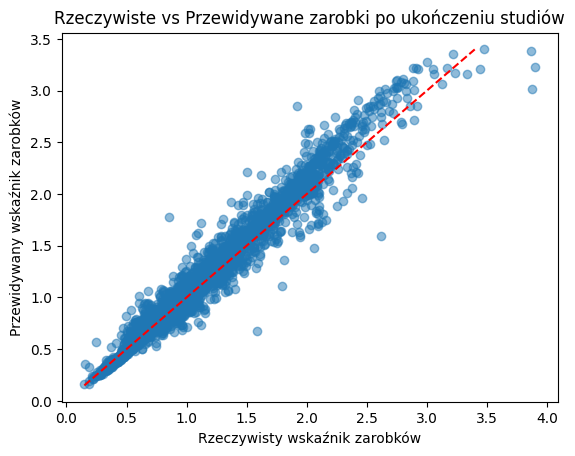

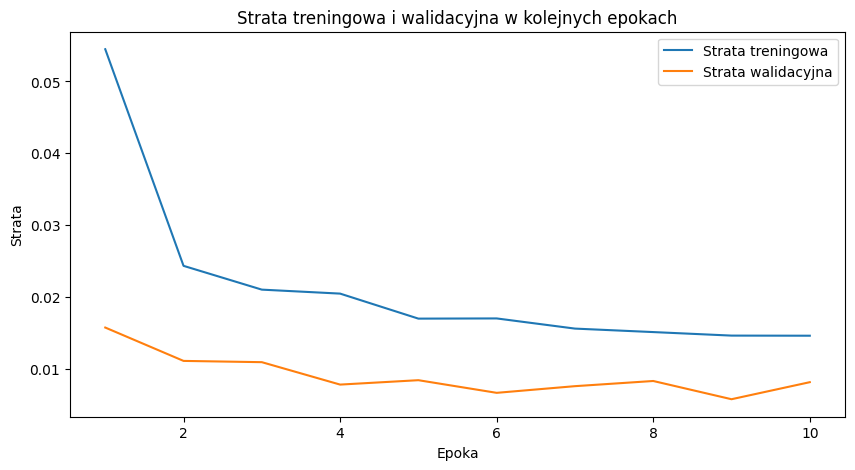

c:\Users\Omen\OneDrive\Desktop\upload\ela_analysis\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20] - Train Loss: 0.0521, Valid Loss: 0.0117
Epoch [2/20] - Train Loss: 0.0237, Valid Loss: 0.0152
Epoch [3/20] - Train Loss: 0.0203, Valid Loss: 0.0168
Epoch [4/20] - Train Loss: 0.0204, Valid Loss: 0.0105
Epoch [5/20] - Train Loss: 0.0179, Valid Loss: 0.0079
Epoch [6/20] - Train Loss: 0.0180, Valid Loss: 0.0079
Epoch [7/20] - Train Loss: 0.0171, Valid Loss: 0.0055
Epoch [8/20] - Train Loss: 0.0167, Valid Loss: 0.0064
Epoch [9/20] - Train Loss: 0.0148, Valid Loss: 0.0049
Epoch [10/20] - Train Loss: 0.0171, Valid Loss: 0.0046
Epoch [11/20] - Train Loss: 0.0148, Valid Loss: 0.0058
Epoch [12/20] - Train Loss: 0.0167, Valid Loss: 0.0065
Epoch [13/20] - Train Loss: 0.0155, Valid Loss: 0.0083
Epoch [14/20] - Train Loss: 0.0155, Valid Loss: 0.0052
Epoch [15/20] - Train Loss: 0.0140, Valid Loss: 0.0098
Epoch [16/20] - Train Loss: 0.0151, Valid Loss: 0.0050
Epoch [17/20] - Train Loss: 0.0145, Valid Loss: 0.0055
Epoch [18/20] - Train Loss: 0.0143, Valid Loss: 0.0052
Epoch [19/20] - Tra

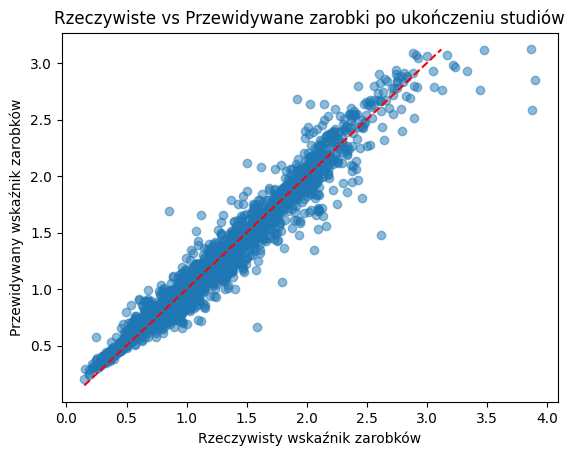

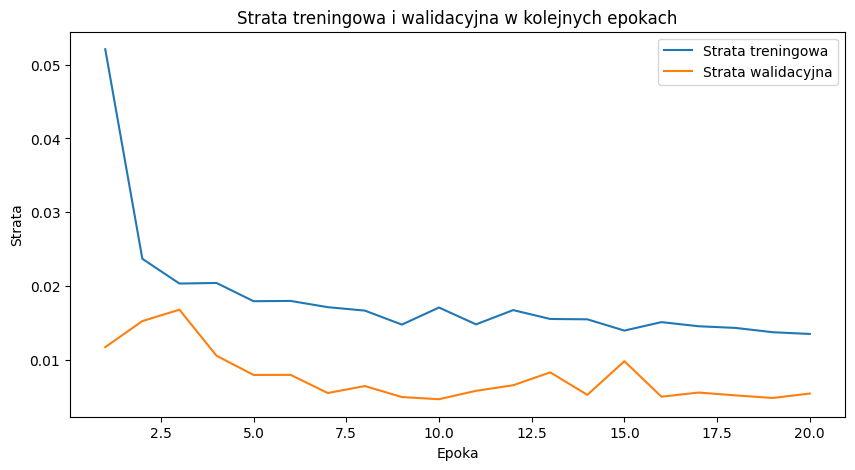

c:\Users\Omen\OneDrive\Desktop\upload\ela_analysis\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30] - Train Loss: 0.0504, Valid Loss: 0.0189
Epoch [2/30] - Train Loss: 0.0258, Valid Loss: 0.0099
Epoch [3/30] - Train Loss: 0.0223, Valid Loss: 0.0197
Epoch [4/30] - Train Loss: 0.0227, Valid Loss: 0.0080
Epoch [5/30] - Train Loss: 0.0174, Valid Loss: 0.0070
Epoch [6/30] - Train Loss: 0.0165, Valid Loss: 0.0055
Epoch [7/30] - Train Loss: 0.0178, Valid Loss: 0.0058
Epoch [8/30] - Train Loss: 0.0159, Valid Loss: 0.0052
Epoch [9/30] - Train Loss: 0.0159, Valid Loss: 0.0083
Epoch [10/30] - Train Loss: 0.0157, Valid Loss: 0.0071
Epoch [11/30] - Train Loss: 0.0151, Valid Loss: 0.0059
Epoch [12/30] - Train Loss: 0.0174, Valid Loss: 0.0050
Epoch [13/30] - Train Loss: 0.0153, Valid Loss: 0.0060
Epoch [14/30] - Train Loss: 0.0160, Valid Loss: 0.0066
Epoch [15/30] - Train Loss: 0.0149, Valid Loss: 0.0054
Epoch [16/30] - Train Loss: 0.0161, Valid Loss: 0.0074
Epoch [17/30] - Train Loss: 0.0148, Valid Loss: 0.0057
Epoch [18/30] - Train Loss: 0.0176, Valid Loss: 0.0067
Epoch [19/30] - Tra

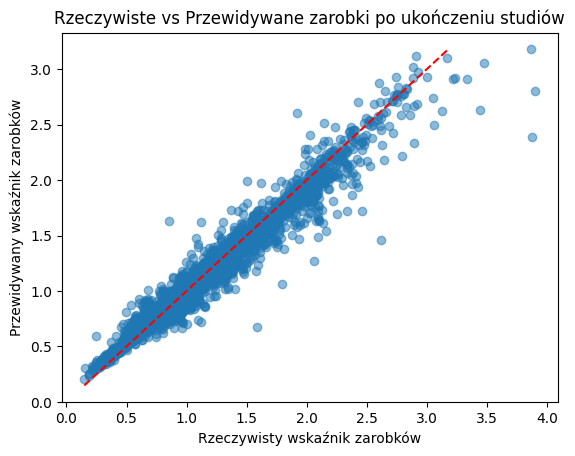

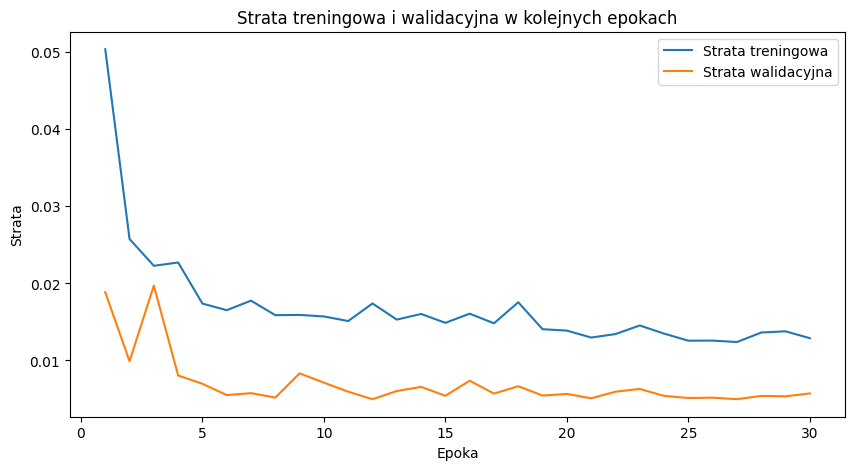

c:\Users\Omen\OneDrive\Desktop\upload\ela_analysis\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - Train Loss: 0.0512, Valid Loss: 0.0116
Epoch [2/50] - Train Loss: 0.0228, Valid Loss: 0.0100
Epoch [3/50] - Train Loss: 0.0221, Valid Loss: 0.0082
Epoch [4/50] - Train Loss: 0.0187, Valid Loss: 0.0136
Epoch [5/50] - Train Loss: 0.0193, Valid Loss: 0.0068
Epoch [6/50] - Train Loss: 0.0165, Valid Loss: 0.0079
Epoch [7/50] - Train Loss: 0.0179, Valid Loss: 0.0071
Epoch [8/50] - Train Loss: 0.0151, Valid Loss: 0.0053
Epoch [9/50] - Train Loss: 0.0167, Valid Loss: 0.0054
Epoch [10/50] - Train Loss: 0.0149, Valid Loss: 0.0056
Epoch [11/50] - Train Loss: 0.0140, Valid Loss: 0.0074
Epoch [12/50] - Train Loss: 0.0150, Valid Loss: 0.0081
Epoch [13/50] - Train Loss: 0.0153, Valid Loss: 0.0070
Epoch [14/50] - Train Loss: 0.0148, Valid Loss: 0.0070
Epoch [15/50] - Train Loss: 0.0140, Valid Loss: 0.0050
Epoch [16/50] - Train Loss: 0.0134, Valid Loss: 0.0049
Epoch [17/50] - Train Loss: 0.0136, Valid Loss: 0.0053
Epoch [18/50] - Train Loss: 0.0139, Valid Loss: 0.0054
Epoch [19/50] - Tra

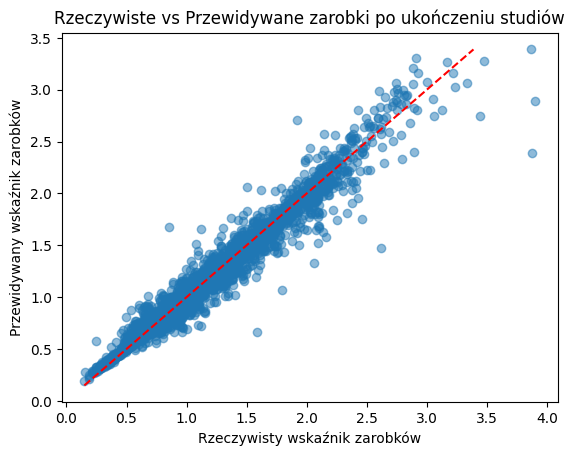

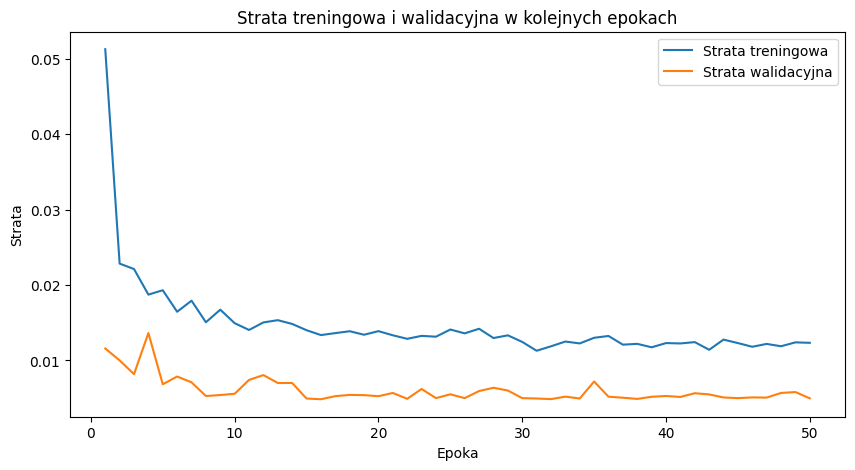

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# ============================================
# 1. Data Preparation
# ============================================
# In this example, we assume you have a DataFrame called 'graduates_data' 
# with the following columns:
#   'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
#   'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
# You mentioned that you might have them already loaded.

graduates_data_copy = graduates_data.copy()
graduates_data_copy = graduates_data_copy[graduates_data_copy['Dziedzina'] != 5]

# Remove rows that have missing values in the key columns
required_cols = [
    'P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina',
    'P_WWZ_P1', 'P_WWZ_P2', 'P_WWZ_P3', 'P_WWZ_P4', 'P_WWZ_P5'
]
graduates_data_copy.dropna(subset=required_cols, inplace=True)

# Encode categorical variables
categorical_cols = ['P_WOJ', 'P_POZIOM', 'P_FORMA', 'Dziedzina']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    graduates_data_copy[col] = le.fit_transform(graduates_data_copy[col])
    label_encoders[col] = le

all_sequences = []
all_targets = []

for _, row in graduates_data_copy.iterrows():
    x_seq, y_seq = build_sequences(row)
    all_sequences.append(x_seq)
    all_targets.append(y_seq)

all_sequences = np.array(all_sequences)  # shape: (N, 4, input_dim)
all_targets = np.array(all_targets)      # shape: (N, 4)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_sequences, all_targets, test_size=0.2, random_state=42
)


# ============================================
# 3. LSTM Model Definition
# ============================================
class AdvancedLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.3):
        super(AdvancedLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Batch Normalization
        self.bn = nn.BatchNorm1d(input_dim)
        
        # Bidirectional LSTM with Dropout
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Fully-connected layer
        self.fc = nn.Linear(hidden_dim * 2, 1)  # bidirectional doubles the hidden_dim

    def forward(self, x):
        # Apply Batch Normalization to the input
        batch_size, seq_length, input_dim = x.size()
        x = self.bn(x.view(-1, input_dim)).view(batch_size, seq_length, input_dim)
        
        lstm_out, _ = self.lstm(x)  # shape: (batch_size, seq_length, hidden_dim * 2)
        out = self.fc(lstm_out)    # shape: (batch_size, seq_length, 1)
        return out.squeeze(-1)     # shape: (batch_size, seq_length)

# Define input_dim (e.g., 6: [P_WOJ, P_POZIOM, P_FORMA, Dziedzina, t, P_WWZ_t])
input_dim = X_train.shape[2]

epochs_list = [10, 20, 30, 50]
train_losses = []
valid_losses = []
for epochs in epochs_list:

    # Initialize model with BatchNorm, 3 LSTM layers, dropout, bidirectional
    model = AdvancedLSTMModel(input_dim=input_dim, hidden_dim=128, num_layers=3, dropout=0.3)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    # ============================================
    # 4. Model Training
    # ============================================

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            preds = model(batch_x)  # shape: (batch_size, seq_length=4)
            
            # Compute loss
            loss = criterion(preds, batch_y)
            
            # Backprop and update
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_x.size(0)
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        valid_loss = 0.0
        
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                valid_loss += loss.item() * batch_x.size(0)

        valid_loss /= len(test_loader.dataset)
        valid_losses.append(valid_loss)
        
        # Step the scheduler
        scheduler.step(valid_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] - "
            f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")

    # ============================================
    # 5. Evaluation on the Test Set
    # ============================================
    model.eval()
    test_preds_list = []
    test_y_list = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            preds = model(batch_x)
            test_preds_list.append(preds)
            test_y_list.append(batch_y)

    # Concatenate predictions and true values
    test_preds = torch.cat(test_preds_list, dim=0).numpy()  # shape: (N_test, 4)
    test_real = torch.cat(test_y_list, dim=0).numpy()       # shape: (N_test, 4)

    # Calculate regression metrics
    mae = mean_absolute_error(test_real.flatten(), test_preds.flatten())
    mse = mean_squared_error(test_real.flatten(), test_preds.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(test_real.flatten(), test_preds.flatten())
    mape = mean_absolute_percentage_error(test_real.flatten(), test_preds.flatten())

    print(f"Test MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R-squared: {r2:.4f}")
    print(f"Test MAPE: {mape:.4f}")

    plt.scatter(test_real.flatten(), test_preds.flatten(), alpha=0.5)
    plt.xlabel("Rzeczywisty wskaźnik zarobków")
    plt.ylabel("Przewidywany wskaźnik zarobków")
    plt.title(f"Rzeczywiste vs Przewidywane zarobki po ukończeniu studiów")
    plt.plot(
        [test_real.flatten().min(), test_preds.flatten().max()],
        [test_real.flatten().min(), test_preds.flatten().max()],
        'r--'
    )  # Line y=x
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Strata treningowa')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Strata walidacyjna')
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.title("Strata treningowa i walidacyjna w kolejnych epokach")
    plt.legend()
    plt.show()

    train_losses = []
    valid_losses = []

# BATCH

In [84]:
import matplotlib.pyplot as plt

# ============================================
# Iterate over batch sizes
# ============================================
batch_sizes = [8, 16, 32, 64]
results = {}
epochs = 10

for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Reinitialize model, optimizer, and scheduler for each batch size
    model = AdvancedLSTMModel(input_dim=input_dim, hidden_dim=128, num_layers=3, dropout=0.3)
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
    
    # Train and validate
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()

            # Forward pass
            preds = model(batch_x)

            # Compute loss
            loss = criterion(preds, batch_y)

            # Backprop and update
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_x.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                preds = model(batch_x)
                loss = criterion(preds, batch_y)
                valid_loss += loss.item() * batch_x.size(0)

        valid_loss /= len(test_loader.dataset)
        valid_losses.append(valid_loss)

        # Step the scheduler
        scheduler.step(valid_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    
    # Evaluation on test set
    model.eval()
    test_preds_list = []
    test_y_list = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            preds = model(batch_x)
            test_preds_list.append(preds)
            test_y_list.append(batch_y)

    test_preds = torch.cat(test_preds_list, dim=0).numpy()
    test_real = torch.cat(test_y_list, dim=0).numpy()

    mae = mean_absolute_error(test_real.flatten(), test_preds.flatten())
    mse = mean_squared_error(test_real.flatten(), test_preds.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(test_real.flatten(), test_preds.flatten())
    mape = mean_absolute_percentage_error(test_real.flatten(), test_preds.flatten())

    results[batch_size] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'Train Losses': train_losses,
        'Valid Losses': valid_losses,
        'Test Predictions': test_preds,
        'Test Real': test_real
    }

    print(f"Results for batch size {batch_size}: "
          f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}")

    # ============================================
    # Generate Plots for Each Batch Size
    # ============================================
    # Loss plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss (Batch Size {batch_size})")
    plt.legend()
    plt.show()

    # Predicted vs Actual scatter plot
    plt.scatter(test_real.flatten(), test_preds.flatten(), alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs Predicted Values (Batch Size {batch_size})")
    plt.plot(
        [test_real.flatten().min(), test_preds.flatten().max()],
        [test_real.flatten().min(), test_preds.flatten().max()],
        'r--'
    )  # Line y=x
    plt.show()

# ============================================
# Summarize Results
# ============================================
for batch_size, metrics in results.items():
    print(f"Batch Size: {batch_size}")
    print(f"  Test MAE: {metrics['MAE']:.4f}")
    print(f"  Test MSE: {metrics['MSE']:.4f}")
    print(f"  Test RMSE: {metrics['RMSE']:.4f}")
    print(f"  Test R2: {metrics['R2']:.4f}")
    print(f"  Test MAPE: {metrics['MAPE']:.4f}")


Training with batch size: 8


c:\Users\Omen\OneDrive\Desktop\upload\ela_analysis\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50] - Train Loss: 0.0561, Valid Loss: 0.0193
Epoch [2/50] - Train Loss: 0.0414, Valid Loss: 0.0187
Epoch [3/50] - Train Loss: 0.0387, Valid Loss: 0.0108
Epoch [4/50] - Train Loss: 0.0374, Valid Loss: 0.0102
Epoch [5/50] - Train Loss: 0.0364, Valid Loss: 0.0081
Epoch [6/50] - Train Loss: 0.0368, Valid Loss: 0.0105
Epoch [7/50] - Train Loss: 0.0355, Valid Loss: 0.0139
Epoch [8/50] - Train Loss: 0.0354, Valid Loss: 0.0129
Epoch [9/50] - Train Loss: 0.0363, Valid Loss: 0.0104
Epoch [10/50] - Train Loss: 0.0327, Valid Loss: 0.0108
Epoch [11/50] - Train Loss: 0.0333, Valid Loss: 0.0153
Epoch [12/50] - Train Loss: 0.0312, Valid Loss: 0.0103
Epoch [13/50] - Train Loss: 0.0323, Valid Loss: 0.0105
Epoch [14/50] - Train Loss: 0.0307, Valid Loss: 0.0089
Epoch [15/50] - Train Loss: 0.0319, Valid Loss: 0.0091
Epoch [16/50] - Train Loss: 0.0313, Valid Loss: 0.0105
Epoch [17/50] - Train Loss: 0.0313, Valid Loss: 0.0253
Epoch [18/50] - Train Loss: 0.0304, Valid Loss: 0.0152
Epoch [19/50] - Tra

KeyboardInterrupt: 